In [ ]:
# COVID-19 negative binomial deaths model

This notebook fits a model using Novel Coronavirus (COVID-19) cases and deaths data by country, provided by JHU CSSE at https://github.com/CSSEGISandData/COVID-19

We begin by estimating the new deaths at each future date $t$ based on new cases declared on each previous date:

$$
\operatorname{E} \bigl[  {nd}_t  \bigr] = \sum_{i=1}^t {nc}_i  \left( 1-s \right)  Pr\bigl[ \text{ dies  at }  t \text{ } \mid \text{ } {nc}_i \bigr ]
$$

where:

&emsp; ${s}$ = probability of survival for a new case 

&emsp; ${nd}_t$ = new deaths on date $t$

&emsp; ${nc}_t$ = new cases on date $t$

The negative binomial distribution is useful to describe this conditional probability. We assume that the lag between a positive test result (i.e. creating a new case) and death due to COVID-19 follows a negative binomial distribution with parameters $n$ and $p$. This can be interpreted as the probability there will be $k$ failures until the $n$-th success for $k+n$ independent and identically distributed trials, each with probability of success $p$. In the above expression $k$ equals the lag, $t-i$, so that:

$$
Pr \bigl[ \text{ dies  at }  t \text{ } \mid \text{ } {nc}_i \bigr ]  =   {{t-i+n-1} \choose { n-1 }} p^{n} (1-p)^{t-i} 
$$


Start by combining cases and deaths data from the Johns Hopkins data for a selected country.

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import nbinom
import matplotlib.pyplot as plt

selected_country = 'United Kingdom'
#selected_country = 'Italy'
#selected_country = 'Spain'
#selected_country = 'US'
#selected_country = 'Sweden'

lockdown_date = None  #for now we do not limit fit to beyond lockdown date

from COVID19 import prepare_data
df = prepare_data(country = selected_country, lockdown_date = None, URLnotfile = True)

print(df.tail())

                   country latest_data_date   cases deaths new_deaths  \
2020-04-24  United Kingdom       2020-04-28  143464  19506        768   
2020-04-25  United Kingdom       2020-04-28  148377  20319        813   
2020-04-26  United Kingdom       2020-04-28  152840  20732        413   
2020-04-27  United Kingdom       2020-04-28  157149  21092        360   
2020-04-28  United Kingdom       2020-04-28  161145  21678        586   

           new_cases new_cases_rate  
2020-04-24      5386      0.0390069  
2020-04-25      4913      0.0342455  
2020-04-26      4463      0.0300788  
2020-04-27      4309      0.0281929  
2020-04-28      3996      0.0254281  


Plot cases, deaths to date. This is very noisy data!

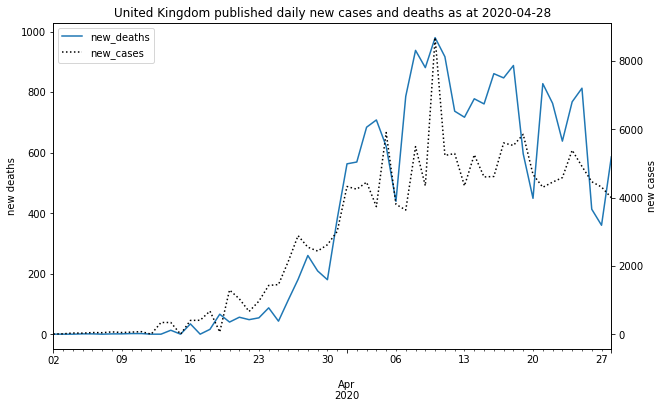

In [8]:
latest_data_date_str = df['latest_data_date'].iloc[0]
ax = df[['new_deaths']].iloc[40:].plot(title=selected_country
       +' published daily new cases and deaths as at '
       +latest_data_date_str, figsize=(10,6))
plt.ylabel('new deaths')
ax2 = df['new_cases'].iloc[40:].plot(secondary_y=True, ax=ax, 
        color='black', linestyle='dotted',label='new_cases')
plt.ylabel('new cases')
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc = 'upper left')  #'lower right'    
plt.show()

By using a negative binomial model to combine cases and deaths, we hope to eliminate some of both of these sources of noise and get a better read on the underlying trends. We fit the model at each date and report the results, looking for trends in survival rates and $ E \left [ \text{days to death} | \text{new infection} \right ] $

We fit the model at each date and report the results, looking for trends in survival rates and $ E \left [ \text{days to death} | \text{new infection} \right ] $

In [9]:
from COVID19 import fit_survival_negative_binomial
df = fit_survival_negative_binomial(df.copy(), ew_halflife_days=50, verbose=True)
s,p,n = tuple(df[['s','p','n']].iloc[-1])   #parameters fitted to latest date row

params = (s,p,n)

proj_df,negbin_probabilities = create_projection_df(params=params, df=df.copy(), 
                                                    project_new_cases_indicator=False)

proj_df['new_deaths'] = proj_df['new_deaths'].replace(0.0, np.nan) #don't plot zero values
proj_df['new_cases'] = proj_df['new_cases'].replace(0.0, np.nan) #don't plot zero values




2020-02-21 parameters= [ 0.99        0.25       10.00866441] , 30.0 days to death, 0 error
2020-02-22 parameters= [ 0.99        0.25       10.00866441] , 30.0 days to death, 0 error
2020-02-23 parameters= [ 0.99        0.25       10.00866441] , 30.0 days to death, 0 error
2020-02-24 parameters= [ 0.99        0.25       10.00866441] , 30.0 days to death, 0 error
2020-02-25 parameters= [ 0.99        0.25       10.00866441] , 30.0 days to death, 0 error
2020-02-26 parameters= [ 0.99        0.25       10.00867479] , 30.0 days to death, 0 error
2020-02-27 parameters= [ 0.99        0.25       10.00868757] , 30.0 days to death, 0 error
2020-02-28 parameters= [ 0.99        0.25       10.00870293] , 30.0 days to death, 0 error
2020-02-29 parameters= [ 0.99        0.25       10.00872101] , 30.0 days to death, 0 error
2020-03-01 parameters= [ 0.99        0.25       10.00874186] , 30.0 days to death, 0 error
2020-03-02 parameters= [ 0.99        0.25       10.00876547] , 30.0 days to death, 0 error

Plot the last fitted negative binomial density

United Kingdom mean time until death 2.0  days between positive test result and death


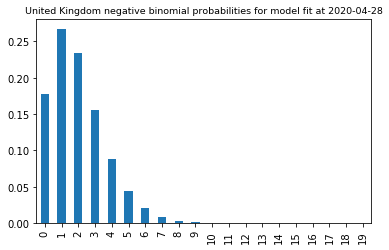

In [10]:
mean = round(n*(1-p)/p,1)
print(selected_country,'mean time until death', str(round(mean,1))
         ,' days between positive test result and death')
ax=pd.Series(negbin_probabilities[0:20]).plot.bar(figsize=(6,3.75))

ax.set_title(selected_country+' negative binomial probabilities for model fit at '
         +latest_data_date_str,fontsize=9.5) 
plt.show()

In [11]:
from COVID19 import create_projection_df
proj_df,negbin_probabilities = create_projection_df(params=params, df=df.copy(), 
                                                    project_new_cases_indicator=False)

proj_df['new_deaths'] = proj_df['new_deaths'].replace(0.0, np.nan) #don't plot zero values
proj_df['new_cases'] = proj_df['new_cases'].replace(0.0, np.nan) #don't plot zero values


the negative binomial model projected for 100 days accounts for 100.0 % of future deaths


Plot evolution of fitted survival rates, s, last 20 days

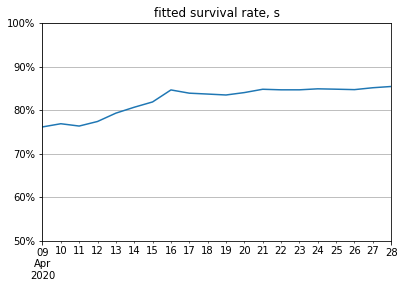

In [12]:
survivalrate_Series = df['s'].tail(20)*100 #in percent
ax = survivalrate_Series.plot(title='fitted survival rate, s', ylim=(50,100), figsize=(6.25,4))
import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.grid()
plt.show()
  

Fit new_cases_rate(t) = exp(k + beta * t) using weighted least squares and choose the median beta from halflife_days weighting in HLD_list

In [14]:
from COVID19 import find_median_halflife_days,project_new_cases
new_cases_df = df[['new_cases','new_cases_rate']]
mask = (new_cases_df['new_cases'].cumsum()>=100)
new_cases_df = new_cases_df.loc[mask]
median_HLD, fit_dict = find_median_halflife_days(new_cases_df, HLD_list = [2,3,4,5,6,7,8,9,10])

median_beta = fit_dict[median_HLD]['beta']

print('use median beta in projection of',round(median_beta,4),'for halflife_days of',median_HLD)
print()

new_cases_df = df[['new_cases','new_cases_rate']].dropna().copy()
new_cases_df,k,beta = project_new_cases(new_cases_df, halflife_days = median_HLD) 

use median beta in projection of -0.0528 for halflife_days of 6



In [15]:
print(selected_country+' new cases growth rate and fitted exponential curve')

United Kingdom new cases growth rate and fitted exponential curve


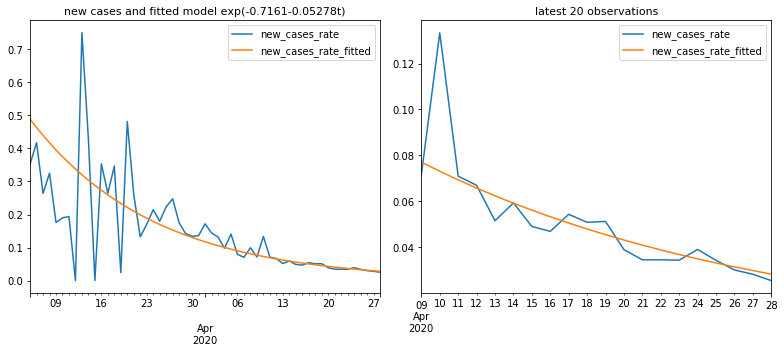

In [16]:
mask1 = (new_cases_df['new_cases'].cumsum()>=100)
mask2 = (new_cases_df.index>new_cases_df['new_cases'].index[-21]) #only last 20 observations
fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
new_cases_df[['new_cases_rate','new_cases_rate_fitted']].loc[mask1].plot(ax=ax)
ax.set_title('new cases and fitted model exp('+str(round(k,4))+str(round(beta,5))+'t)', fontsize=11)
new_cases_df[['new_cases_rate','new_cases_rate_fitted']].loc[mask2].plot(ax=ax2)
#ax2.set_title('new_cases_rate_fitted(t) = exp(k+t.beta)', fontsize=11) 
ax2.set_title('latest 20 observations', fontsize=11)
fig.tight_layout()
plt.show()

Plot evolution of $\beta$ parameters for $\text{growth rate in new cases}(t)  = \exp (k+\beta t)$ fits across various countries. $\beta$ Values below around $-0.025$ imply new cases are diminishing in *absolute* and not just relative terms.

['United Kingdom', 'Italy', 'Spain', 'US', 'Sweden'] added to summary_dict


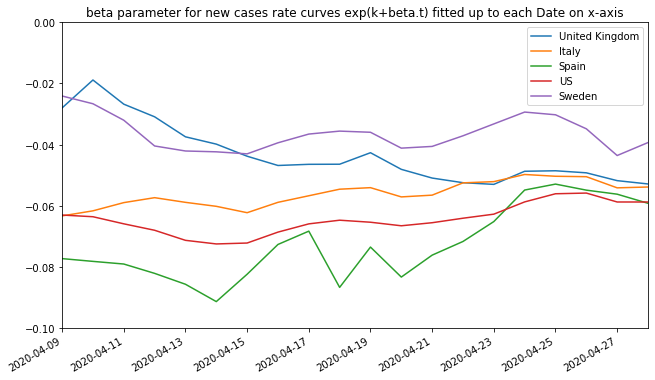

In [22]:
from COVID19 import compare_new_cases_rate_beta
country_list = ['United Kingdom','Italy','Spain','US','Sweden'] #, 'Germany']
summary_dict = compare_new_cases_rate_beta(country_list=country_list, last_n_days=20)
beta_df = pd.DataFrame()
for country in country_list:
    cSeries = summary_dict[country]['beta']; cSeries.name=country
    beta_df = pd.concat([beta_df,cSeries], axis=1)
beta_df = beta_df.sort_index()     
beta_df.plot(figsize=(10.5,6.25),ylim=(-0.1,0.0), title = 
             'beta parameter for new cases rate curves exp(k+beta.t) fitted up to each Date on x-axis')

In [ ]:
show the mid projection

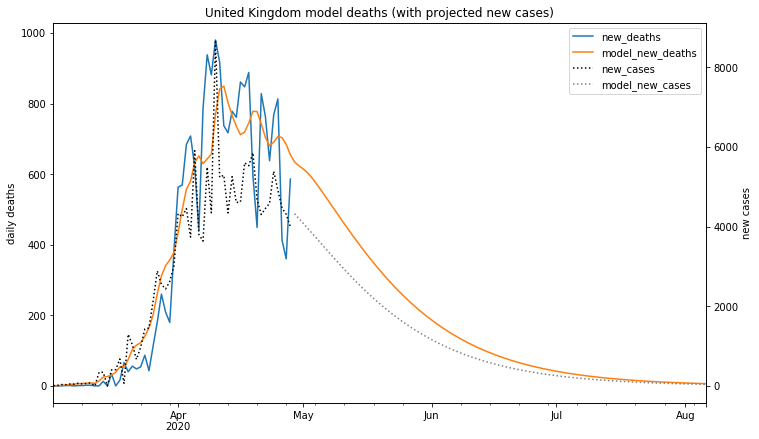

In [24]:
df['k'] = k
df['beta'] = beta
proj_df,negbin_probabilities = create_projection_df(params=(s,p,n), df=df, 
                                                    project_new_cases_indicator=True)
plot_df = proj_df[['model_new_deaths']]
latest_data_date = pd.Timestamp(df['latest_data_date'].iloc[0])
mask = (proj_df.index>latest_data_date)
plot_df.at[mask,'model_new_cases']= proj_df.loc[mask,'new_cases']
plot_df.at[~mask,'new_deaths'] = proj_df.loc[~mask,'new_deaths']
plot_df.at[~mask,'new_cases'] = proj_df.loc[~mask,'new_cases']
title_str = selected_country+' model deaths (with projected new cases)'
ax = plot_df[['new_deaths','model_new_deaths']].iloc[40:].plot(title=title_str, figsize=(11.7,7))
plt.ylabel('daily deaths')
ax2 = plot_df[['new_cases','model_new_cases']].iloc[40:].plot(secondary_y=True, ax=ax, 
             color=['black','grey'], linestyle='dotted',label='new_cases')
plt.ylabel('new cases')
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc = 'best')  #'lower right'
plt.rcParams["figure.dpi"] = 120  #higher DPI plots
plt.show()

In [28]:
current_deaths = int(df['deaths'].iloc[-1])
accum_deaths = int(proj_df['deaths'].iloc[-1])
print('projected cumulative deaths by',proj_df.index[-1].strftime('%Y-%m-%d'),'of',accum_deaths,
', being',int(100*current_deaths/accum_deaths),'% of',current_deaths,'deaths to date')

projected cumulative deaths by 2020-08-06 of 38736 , being 55 % of 21678 deaths to date


add 90% confidence bounds, assuming range between 5th and 95th percentile of residuals

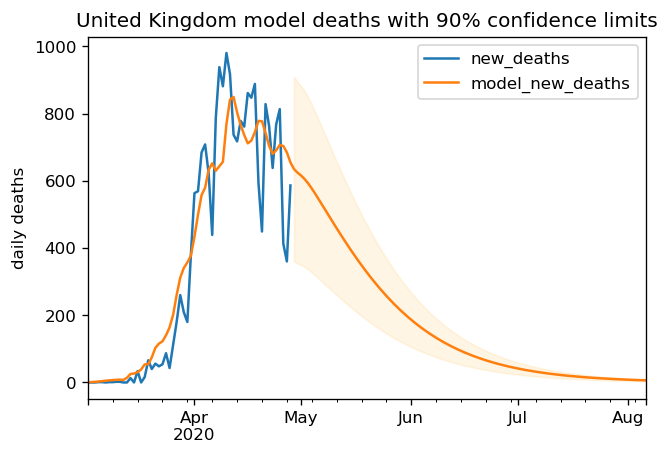

In [33]:
if selected_country!='Sweden':
    threshold_daily_deaths = 100
else:
    threshold_daily_deaths = 20    
latest_data_date = proj_df['latest_data_date'].iloc[0]
mask = (proj_df['model_new_deaths']>threshold_daily_deaths) & (proj_df.index<=latest_data_date)
proj_df.at[mask,'error'] = proj_df.loc[mask,'new_deaths']-proj_df.loc[mask,'model_new_deaths']
proj_df.at[mask,'error'] = proj_df.loc[mask,'error'] / proj_df.loc[mask,'model_new_deaths']
l_bound, u_bound = np.percentile(proj_df.loc[mask,'error'].values, 
                                         [5,95], interpolation = 'linear')
#rebalance bounds around zero
upper_bound = (u_bound- l_bound)/2.
lower_bound = (l_bound- u_bound)/2.

plot_df = proj_df[['model_new_deaths']]
latest_data_date = pd.Timestamp(df['latest_data_date'].iloc[0])
mask = (proj_df.index>latest_data_date)  
plot_df.at[mask,'5% bound new_deaths'] = proj_df.loc[mask,'model_new_deaths']*(1+lower_bound)
plot_df.at[mask,'95% bound new_deaths'] = proj_df.loc[mask,'model_new_deaths']*(1+upper_bound)
plot_df.at[mask,'model_new_cases']= proj_df.loc[mask,'new_cases']
plot_df.at[~mask,'new_deaths'] = proj_df.loc[~mask,'new_deaths']
plot_df.at[~mask,'new_cases'] = proj_df.loc[~mask,'new_cases']
title_str = selected_country+' model deaths with 90% confidence limits'
ax = plot_df[['new_deaths','model_new_deaths']].iloc[40:].plot(title=title_str, figsize=(6,4))
ax.fill_between(plot_df['5% bound new_deaths'].index, plot_df['5% bound new_deaths'], plot_df['95% bound new_deaths'], 
                color='orange', alpha=.1)   
plt.ylabel('daily deaths')
plt.show()